In [27]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

c:\Users\Pedro Antônio Silva\Desktop\Semestre 4\Machine Learning\proj_1\ames\data


In [29]:
def nonNull_percent(label, null_value = 0 ):
    f = data[label] != null_value
    return (data[label][f].value_counts().sum()/data[label].shape[0] *100)

def heatMapCorr(labels):
    correlation_matrix = data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

In [30]:
dumm = []
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dumm.append(col)
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Columns: 166 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(118)
memory usage: 1.4 MB
From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "N

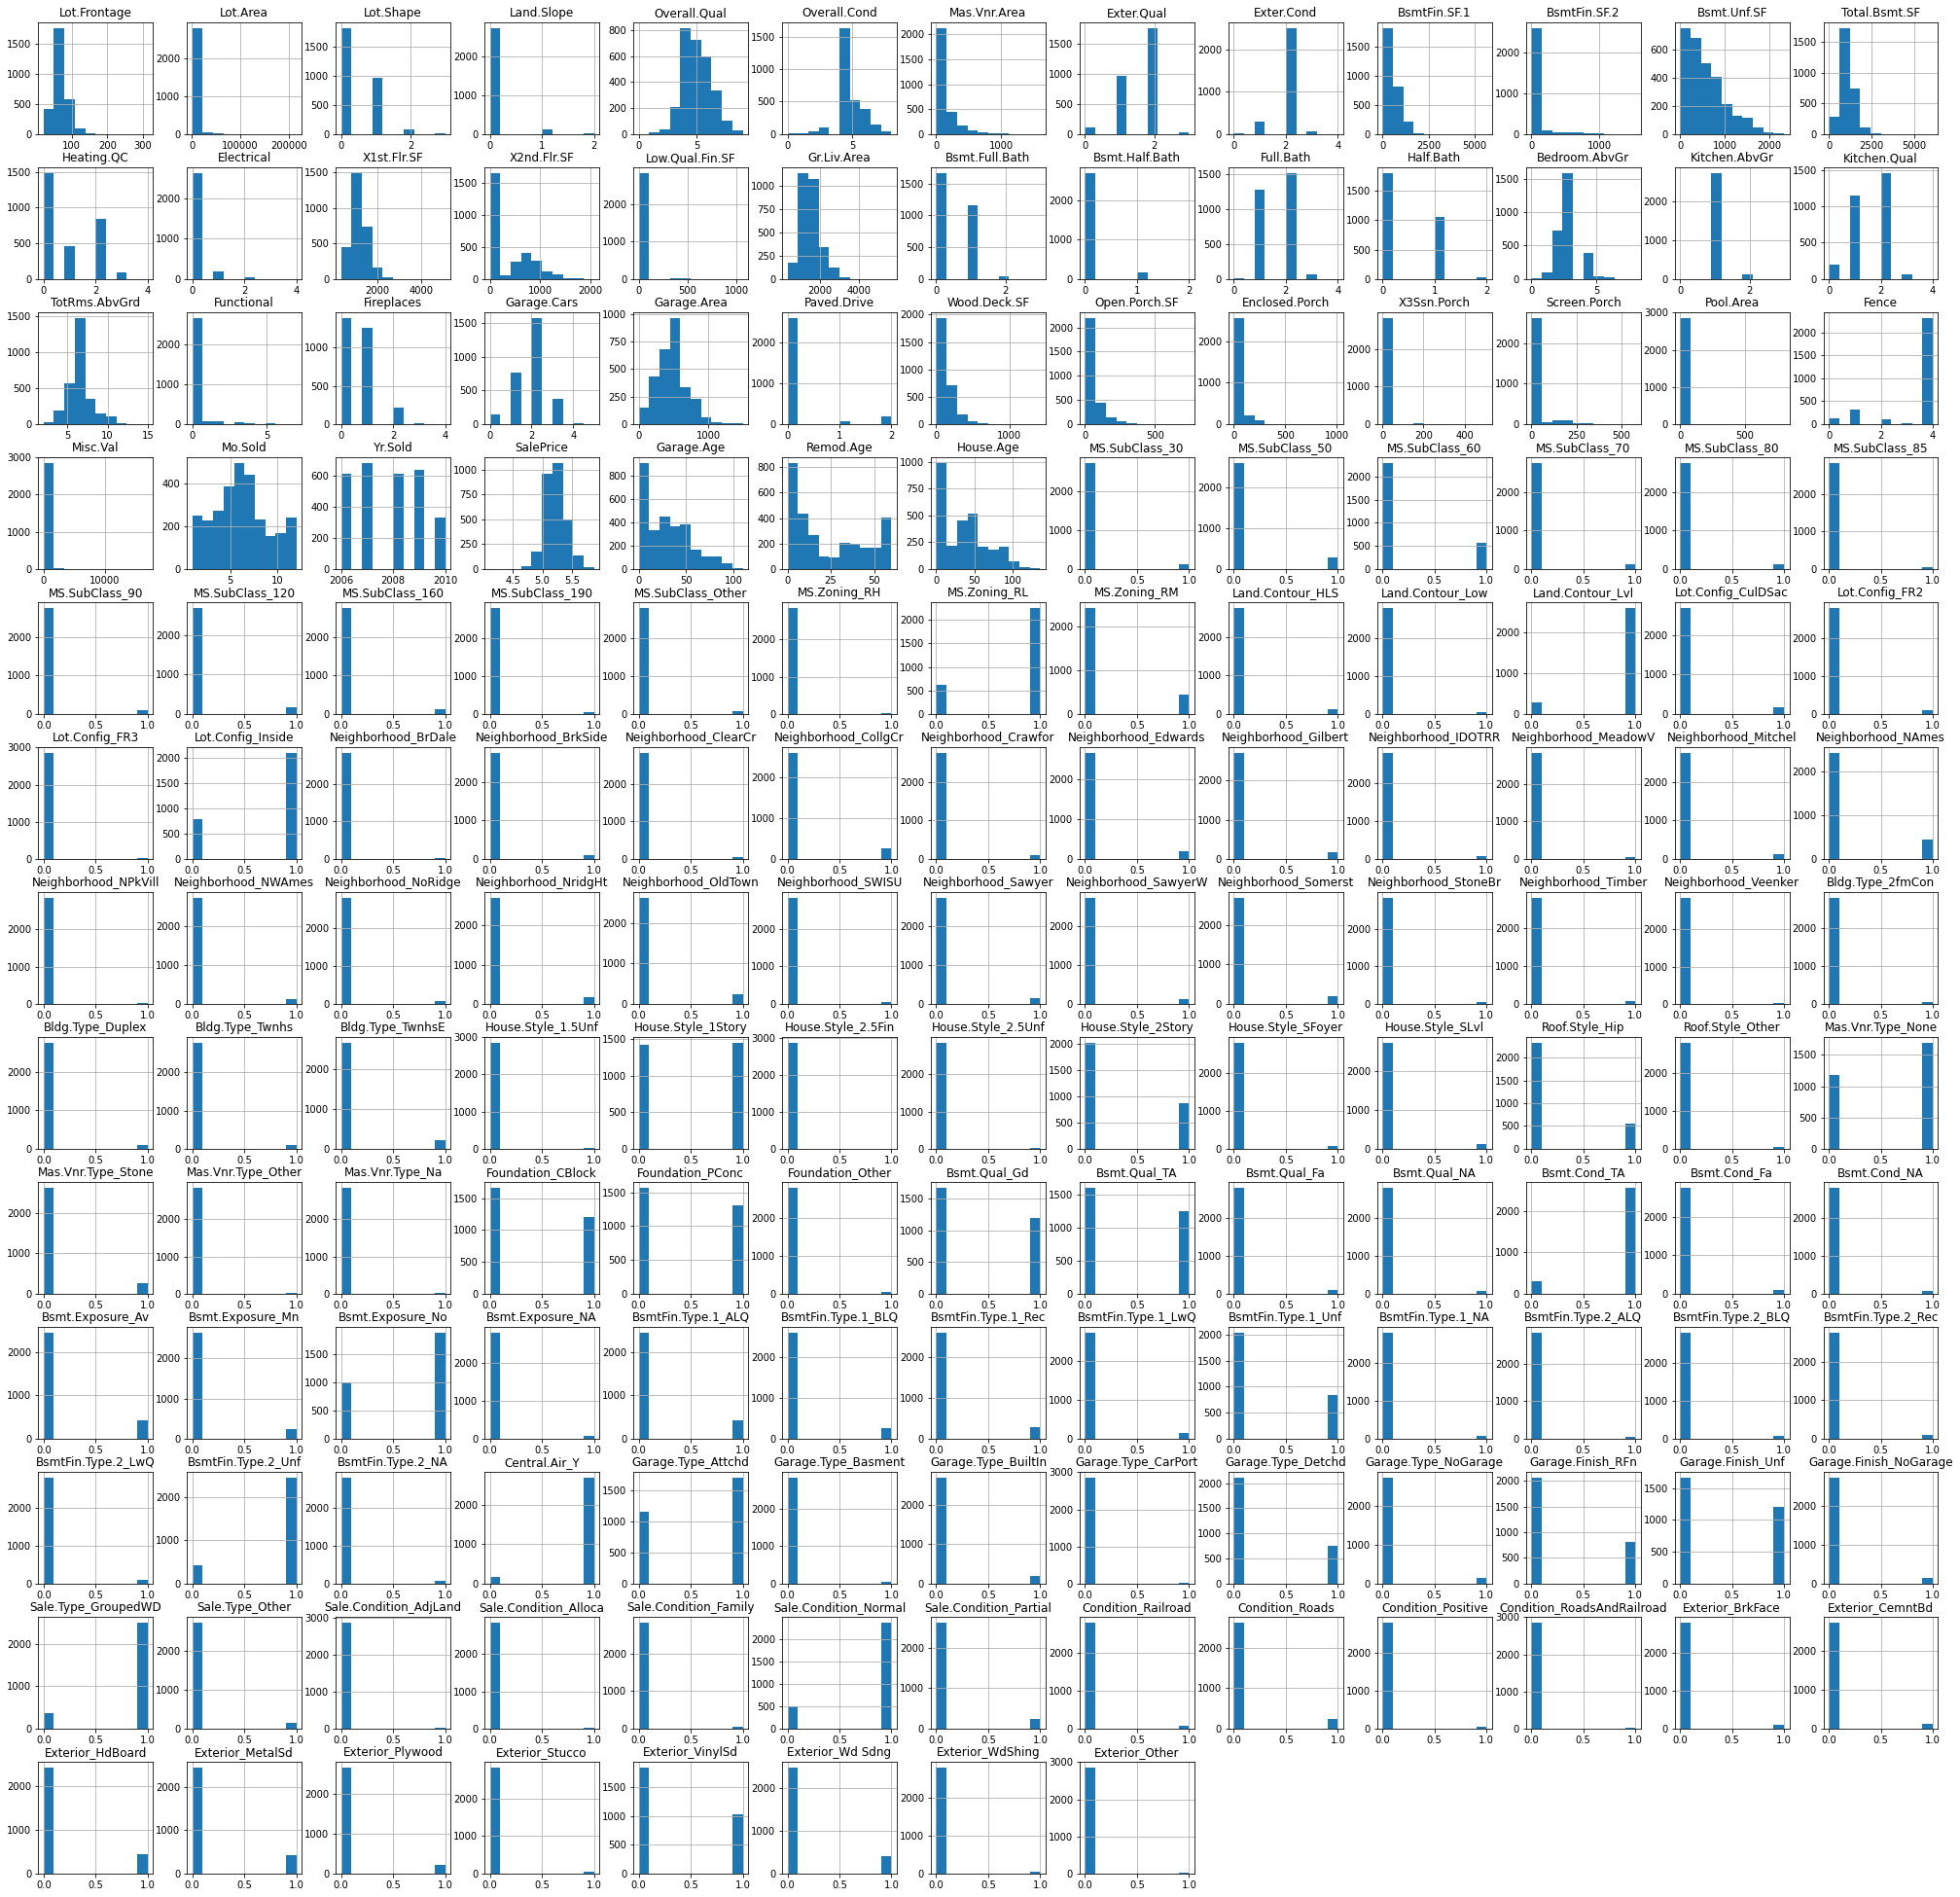

In [31]:
data = model_data
data.hist(figsize=(35,35))
print()

**Checking the distribution and format of the data**

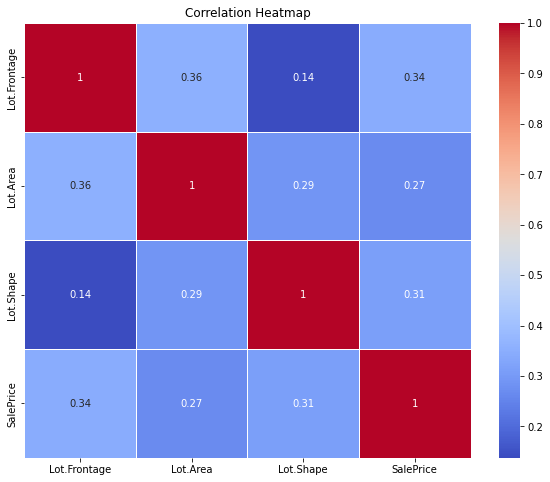

In [32]:
# Lot related features
lot_cat = ["Lot.Frontage","Lot.Area","Lot.Shape"]
heatMapCorr(lot_cat)

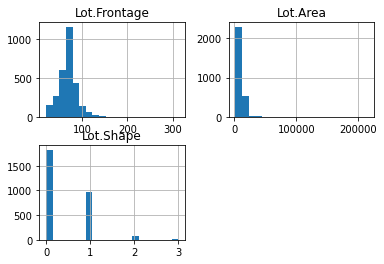

In [33]:
# all seem relevant to the end result, so let's check their looks
data[lot_cat].hist(bins=20)
print()

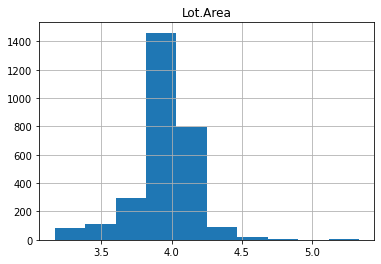

In [34]:
# seems like lot area might use some logs
pd.DataFrame(np.log10(data["Lot.Area"])).hist()
print()

In [35]:
print(f'correlation with target: {data[["Land.Slope","SalePrice"]].corr()["SalePrice"][0]}')
# not the highest correlation, so let's check how much of it isn't null or common:
nonNull_percent("Land.Slope")
# only four percent of the data has a non-null value for this feature, so I will store it for now as a potential removal, as it also does not impact too much acording to the correlation.
lessThan5p = ["Land.Slope"]

correlation with target: 0.0617546485052981


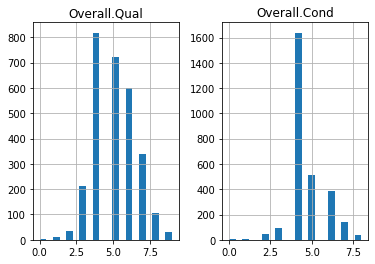

In [36]:
# OverAll features
over_cat = ["Overall.Qual","Overall.Cond"]
data[over_cat].hist(bins=20) # these seem to reflect a rating
print()

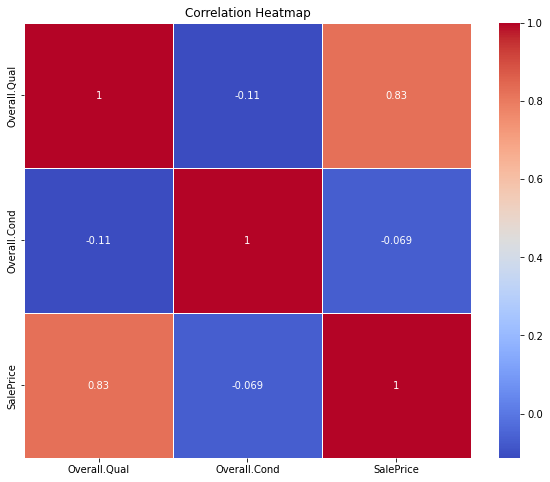

43.06569343065693


In [37]:
# data["Overall.Rat"]  = data["Overall.Cond"] + data["Overall.Qual"]

heatMapCorr(over_cat)
# the overWhelming majority of houses in the dataSet are 4 in cond, so let's see if the remainder is significant
print(nonNull_percent("Overall.Cond",4))
# it is, so the feature may still differ one house to another in quite a few cases, no alterations will be done here and store as ratings
ratings = over_cat # we may like to avoid transforming those.

# data = data.drop(columns=over_cat)

0.446062177443733
40.25026068821689


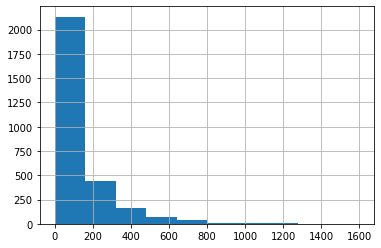

In [38]:
print(data[["Mas.Vnr.Area","SalePrice"]].corr()["SalePrice"][0]) # high correlation...
data["Mas.Vnr.Area"].hist()
print(nonNull_percent("Mas.Vnr.Area")) # has a good non-null amount...
right_skewed = ["Mas.Vnr.Area"]

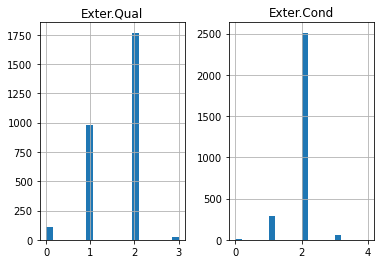

In [39]:
# External features
exter_cat = ["Exter.Qual","Exter.Cond"]
data[exter_cat].hist(bins=20) # these seem to reflect a more umbalanced rating
print()

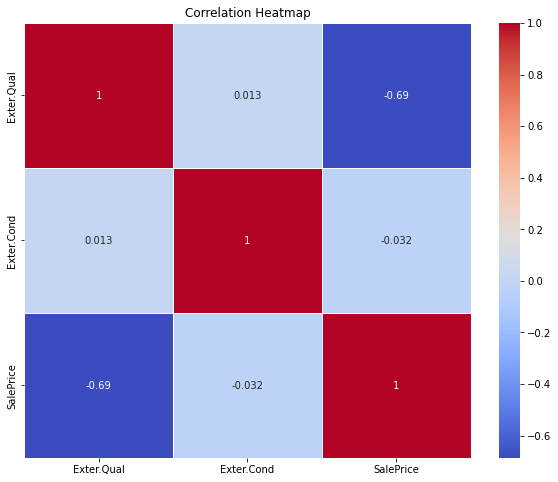

qual: 38.581856100104275
cond: 12.75634341327772


In [40]:
# data["Exter.Rat"] = data["Exter.Qual"] + data["Exter.Cond"]
heatMapCorr(exter_cat)
# the overWhelming majority of houses in the dataSet are rated 2 on both, so let's see if the remainder is significant
print(f"qual: {nonNull_percent(exter_cat[0],2)}")
print(f"cond: {nonNull_percent(exter_cat[1],2)}")
# it is, so the feature may still differ one house to another in quite a few cases, no alterations will be done here and be stored as ratings
ratings.append(exter_cat[0])
ratings.append(exter_cat[1])
# data = data.drop(columns=exter_cat)

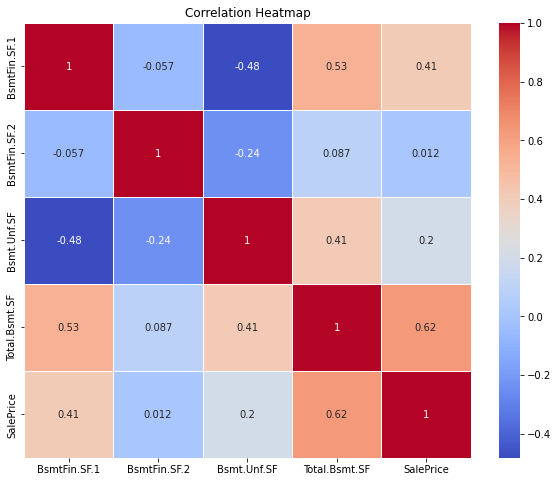

In [41]:
# Basement Features (Area)
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF","Total.Bsmt.SF"]
heatMapCorr(basement_cat) # checking relevance...

BsmtFin.SF.1 68.57838025721237
BsmtFin.SF.2 12.02641640597845
Bsmt.Unf.SF 91.83176920403197
Total.Bsmt.SF 97.46263468891206


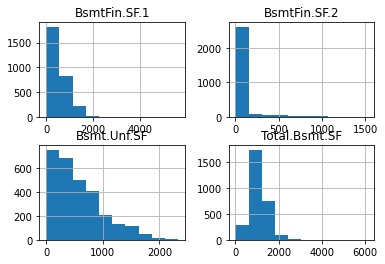

In [42]:
data[basement_cat].hist()
for cat in basement_cat:
    print(cat, nonNull_percent(cat))
    
right_skewed += ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF"]

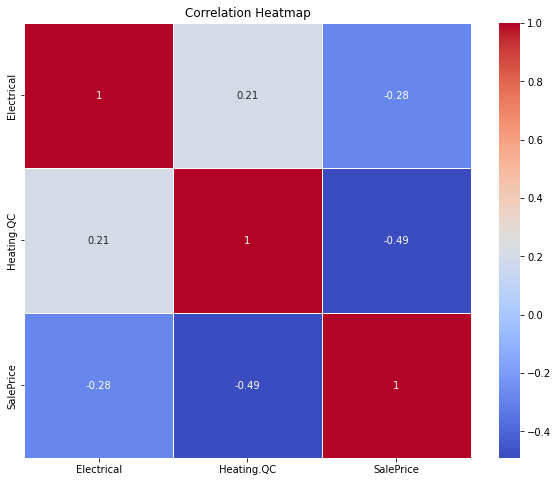

8.168230795968022
48.348974626346894


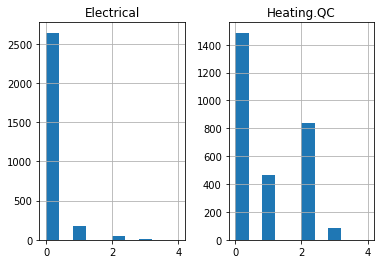

In [43]:
# Heating and Eletrical categories
he_cat = ["Electrical","Heating.QC"]
heatMapCorr(he_cat)  # seems relevant enough
data[he_cat].hist()
print(nonNull_percent(he_cat[0]))
print(nonNull_percent(he_cat[1]))
# storing the cat
categories = he_cat
right_skewed.append(he_cat[0])
right_skewed.append(he_cat[1])

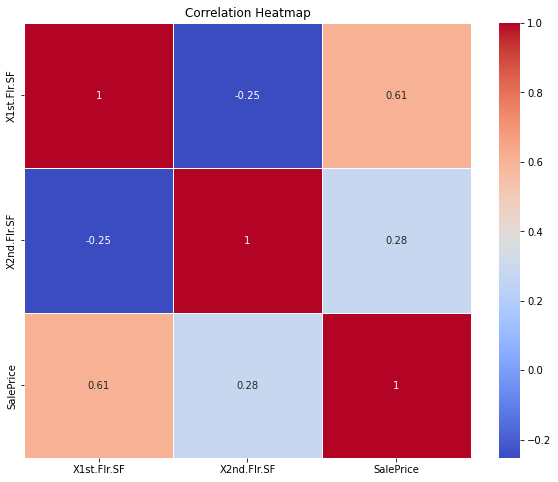

100.0
42.75286757038582


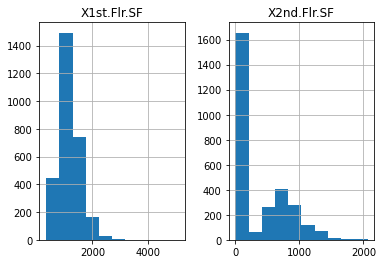

In [44]:
# xcat features
xcat = ["X1st.Flr.SF","X2nd.Flr.SF"] 
heatMapCorr(xcat)
data[xcat].hist()
print(nonNull_percent(xcat[0]))
print(nonNull_percent(xcat[1]))
# No worries it seems, still, what is it?
right_skewed.append(xcat[1])

In [45]:
data[["Low.Qual.Fin.SF","SalePrice"]].corr()["SalePrice"][0]
nonNull_percent("Low.Qual.Fin.SF")
lessThan5p.append("Low.Qual.Fin.SF")

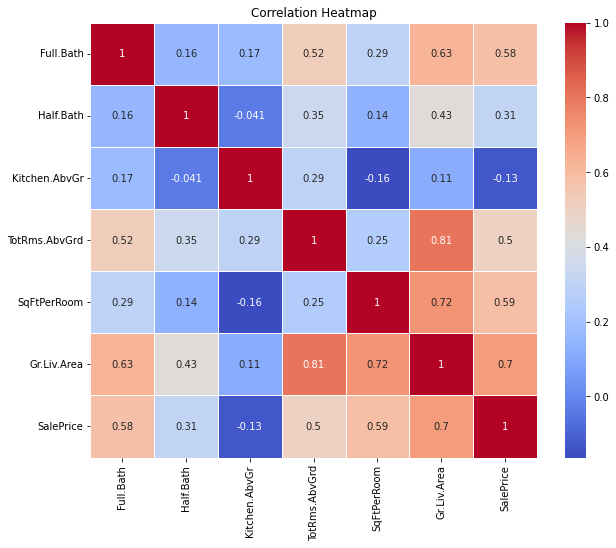

array([[<AxesSubplot:title={'center':'Full.Bath'}>,
        <AxesSubplot:title={'center':'Half.Bath'}>],
       [<AxesSubplot:title={'center':'Kitchen.AbvGr'}>,
        <AxesSubplot:title={'center':'TotRms.AbvGrd'}>],
       [<AxesSubplot:title={'center':'SqFtPerRoom'}>,
        <AxesSubplot:title={'center':'Gr.Liv.Area'}>]], dtype=object)

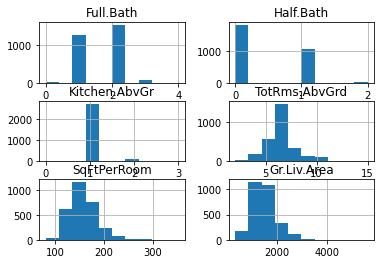

In [46]:
rooms = ["Full.Bath","Half.Bath", "Kitchen.AbvGr", "TotRms.AbvGrd"]
data["SqFtPerRoom"] =  data["Gr.Liv.Area"] / (data["TotRms.AbvGrd"] +
                                                       data["Full.Bath"] +
                                                       data["Half.Bath"] +
                                                       data["Kitchen.AbvGr"])
heatMapCorr(rooms+["SqFtPerRoom","Gr.Liv.Area"])
data[rooms + ["SqFtPerRoom","Gr.Liv.Area"]].hist()

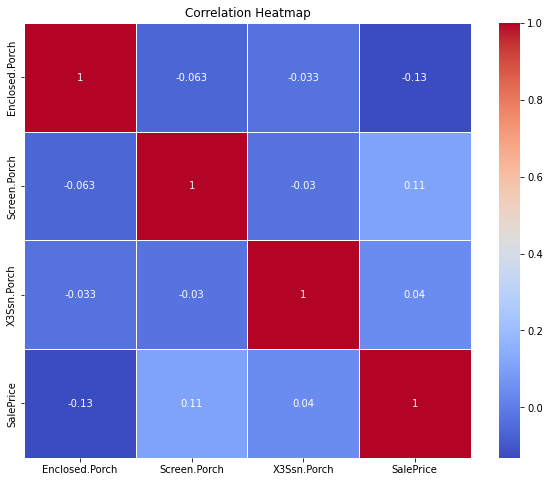

15.363225582203684
8.86339937434828
1.251303441084463


In [47]:
# Porch Features
porch_cat = ["Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
heatMapCorr(porch_cat) # low relevance for everyone


for cat in porch_cat:
    print(nonNull_percent(cat))

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

class LogTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        # Initialize the quantile transformer
        return self

    def transform(self, X):
        return np.log10(X)

In [49]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, RobustScaler, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer

model_data = data.copy()
model_data = model_data.drop(columns=["Pool.Area","Misc.Val"])
y = model_data["SalePrice"].copy()
X = model_data.drop(columns=["SalePrice"]).copy()
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=12,)

colT = ColumnTransformer(transformers=[
    ("log", Pipeline([
        ("Log10",LogTransformer())
    ]), ["Lot.Area"]),
        ("Ppow", Pipeline([
        ("pow",PowerTransformer())
    ]), right_skewed),
], remainder="passthrough")

piped_model = Pipeline([
    ("column transformer", colT),
    # ("Poly", PolynomialFeatures()),
    ("Scaler", StandardScaler()),
    ("Ridge", Ridge())
])

param_grid_r = {
    'Ridge__alpha': [0.1, 1.0, 10.0],  # List of alpha values to try
    # 'Poly__degree': [0, 1, 2],
}

param_grid_cat = {
    'iterations': [100, 200, 300],  # Number of boosting iterations
    'depth': [4, 6, 8],             # Depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
}

grid_search_r = GridSearchCV(piped_model, param_grid_r, 
                              cv=5)

grid_search_r.fit(Xtrain,ytrain)

ypred = grid_search_r.predict(Xtest)
RMSE = np.sqrt(mean_squared_error(ytest, ypred))
print(f"RMSE = {RMSE}")
error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE = 0.05051001073762261
Average error is 12.33%


In [50]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean_eng.pkl'
with open(clean_data_path, 'wb') as file:
    pickle.dump(model_data, file)